In [45]:
#Imports
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
import numpy as np
import re
import warnings



In [5]:
#Load and Combine CSV Files and checking shape
data_path = r'C:\\Users\\thisi\\code\\DataCareerAnalysis\\data' 

# Use glob to get all the CSV file paths
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

# List to hold the data frames
df_list = []

# Loop through the CSV files and read them into data frames
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenate all the data frames into one
df_combined = pd.concat(df_list, ignore_index=True)
df_original = df_combined
# df_combined = df_original # Revery to original 


print("Shape of df_combined:", df_combined.shape)
df_combined.head()


Shape of df_combined: (4183, 16)


,Keywords,Search Location,Job ID,Title,Company,City,Country,Type,Seniority,Posted,Collected Date,Applicants,Employees,Industry,Job URL,Job Description
0,Data Analyst,European Union,3927615333,Data Analyst Intern\r\nData Analyst Intern,Foxintelligence,Paris,France,On-site,Internship,2024-05-04,2024-08-02,100.0,51.0,Market Research,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nChez Foxintelligence, nous s..."
1,Data Analyst,European Union,3985582505,Data Analyst Intern\r\nData Analyst Intern,Echo Analytics,Paris,France,On-site,NaN,2024-07-19,2024-08-02,0.0,51.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\n🚀 Founded in 2021, Echo's na..."
2,Data Analyst,European Union,3988104437,Junior Data Analyst\r\nJunior Data Analyst,ISO,Cracow,Poland,On-site,Entry level,2024-07-31,2024-08-02,85.0,5001.0,Insurance,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nCompany Description\r\n\r\nW..."
3,Data Analyst,European Union,3986942433,Junior Data Analyst\r\nJunior Data Analyst,Intale,Athens,Greece,On-site,Associate,2024-07-30,2024-08-02,100.0,11.0,IT Services and IT Consulting,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nIntale is a VC backed retail..."
4,Data Analyst,European Union,3987193886,Data Analyst Intern\r\nData Analyst Intern wit...,Mirakl,Paris,France,On-site,NaN,2024-07-30,2024-08-02,93.0,501.0,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r\nMirakl is the global leader ..."


In [6]:
#Cleaning Data
# Cleaning new line '\n' from Title and Job Description columns 
df_combined[['Title','Job Description']] = df_combined[['Title','Job Description']].replace('\n', ' ', regex=True) 

# Removeing 'full time', 'contract' from Seniority column
df_combined['Seniority'] = df_combined['Seniority'].replace('Contract', 'N/A', regex=True) 
df_combined['Seniority'] = df_combined['Seniority'].replace('Full-time', 'N/A', regex=True) 
df_combined['Seniority'] = df_combined['Seniority'].replace('Temporary', 'N/A', regex=True) 
df_combined['Seniority'] = df_combined['Seniority'].replace('N/A', 'Info Not Provided', regex=True) 



# Strip 'About the Job' from Job Descriptions 
# df_combined['Job Description'] = df_combined['Job Description'].str[15:] 

# Convert dates to Dateframe
df_combined['Posted'] = pd.to_datetime(df_combined['Posted']) 
df_combined['Collected Date'] = pd.to_datetime(df_combined['Collected Date'])
# print(df_combined.info())

# Fill NaN values in Employees and Applicants 
df_combined[['Employees', 'Applicants']] = df_combined[['Employees', 'Applicants']].fillna(0)
nan_counts = df_combined.isna().sum()
print('\nNaN counts per Column')
print(nan_counts)

# Convert Applicants & Employee Column TYPE (Floats > Integers) 
df_combined[['Employees', 'Applicants']] = df_combined[['Employees', 'Applicants']].astype(int)

# temp['year'] = temp['Posted'].dt.year
# temp
df_combined
print('\nColumn Types')

print(df_combined.dtypes)




NaN counts per Column
Keywords             0
Search Location      0
Job ID               0
Title                0
Company              0
City                 0
Country            900
Type                 0
Seniority          922
Posted             107
Collected Date       0
Applicants           0
Employees            0
Industry            72
Job URL              0
Job Description      0
dtype: int64

Column Types
Keywords                   object
Search Location            object
Job ID                      int64
Title                      object
Company                    object
City                       object
Country                    object
Type                       object
Seniority                  object
Posted             datetime64[ns]
Collected Date     datetime64[ns]
Applicants                  int32
Employees                   int32
Industry                   object
Job URL                    object
Job Description            object
dtype: object


In [7]:
# Cleaned Data.head()
df_combined.head()
# df_combined

,Keywords,Search Location,Job ID,Title,Company,City,Country,Type,Seniority,Posted,Collected Date,Applicants,Employees,Industry,Job URL,Job Description
0,Data Analyst,European Union,3927615333,Data Analyst Intern\r Data Analyst Intern,Foxintelligence,Paris,France,On-site,Internship,2024-05-04,2024-08-02,100,51,Market Research,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Chez Foxintelligence, nous so..."
1,Data Analyst,European Union,3985582505,Data Analyst Intern\r Data Analyst Intern,Echo Analytics,Paris,France,On-site,NaN,2024-07-19,2024-08-02,0,51,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r 🚀 Founded in 2021, Echo's nar..."
2,Data Analyst,European Union,3988104437,Junior Data Analyst\r Junior Data Analyst,ISO,Cracow,Poland,On-site,Entry level,2024-07-31,2024-08-02,85,5001,Insurance,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Company Description\r \r We h..."
3,Data Analyst,European Union,3986942433,Junior Data Analyst\r Junior Data Analyst,Intale,Athens,Greece,On-site,Associate,2024-07-30,2024-08-02,100,11,IT Services and IT Consulting,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Intale is a VC backed retail-..."
4,Data Analyst,European Union,3987193886,Data Analyst Intern\r Data Analyst Intern with...,Mirakl,Paris,France,On-site,NaN,2024-07-30,2024-08-02,93,501,Software Development,https://www.linkedin.com/jobs/search/?currentJ...,"""About the job\r Mirakl is the global leader i..."


Initial Exploration 

In [8]:
df_combined.describe()

,Job ID,Posted,Collected Date,Applicants,Employees
count,4.183000e+03,4076,4183,4183.000000,4183.000000
mean,3.960787e+09,2024-07-13 21:29:29.970559232,2024-08-02 00:00:00,48.021038,1796.684437
min,3.114762e+09,2023-09-07 00:00:00,2024-08-02 00:00:00,0.000000,0.000000
25%,3.962213e+09,2024-07-12 00:00:00,2024-08-02 00:00:00,1.000000,11.000000
50%,3.977283e+09,2024-07-26 00:00:00,2024-08-02 00:00:00,41.000000,201.000000
75%,3.986693e+09,2024-07-30 00:00:00,2024-08-02 00:00:00,100.000000,1001.000000
max,3.991547e+09,2024-08-02 00:00:00,2024-08-02 00:00:00,100.000000,10001.000000
std,5.798214e+07,NaN,NaN,41.990628,3358.253188


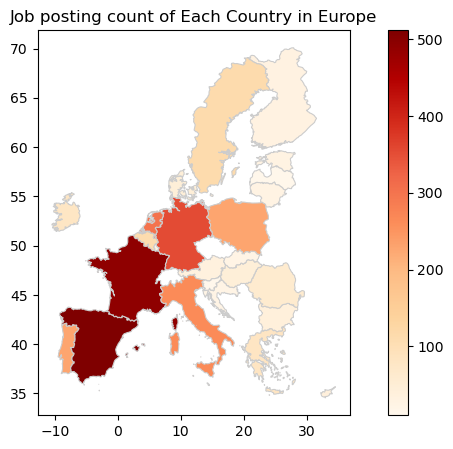

In [9]:
#GeoPandas Visualization of Count by Country 

# Count the instances of each country
country_counts = df_combined['Country'].value_counts()

# Convert to dictionary
country_counts_dict = country_counts.to_dict()

# Convert the dictionary to a DataFrame
counts_df = pd.DataFrame(list(country_counts_dict.items()), columns=['Country', 'Count'])

# Load Europe GeoJSON
geojson_path = 'C:\\Users\\thisi\\code\\DataCareerAnalysis\\europe.geojson'
eu_countries = gpd.read_file(geojson_path)

# # Inspect the columns of the GeoDataFrame
# print(eu_countries.columns)

# eu_countries_df = pd.DataFrame(eu_countries)
# eu_countries_df.head()

# Merge data with geographical data using 'NAME' as the key
merged = eu_countries.set_index('NAME').join(counts_df.set_index('Country'))

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Job posting count of Each Country in Europe')
plt.show()


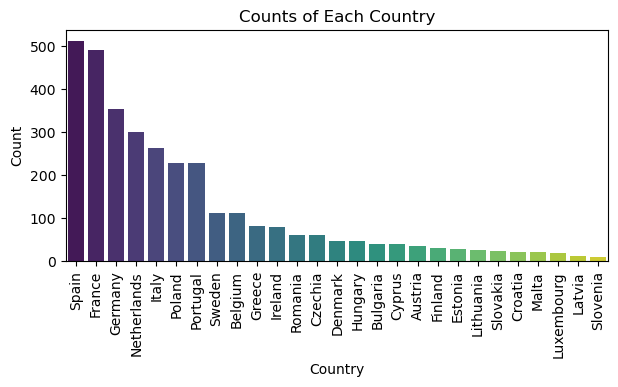

In [10]:
#Bar Chart of Count of Counties

# Convert dictionary to DataFrame for easier plotting with Seaborn
counts_df = pd.DataFrame(list(country_counts_dict.items()), columns=['Country', 'Count'])

plt.figure(figsize=(7, 3))
sns.barplot(x='Country', y='Count', hue = 'Country', data=counts_df, palette='viridis')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Counts of Each Country')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, '')

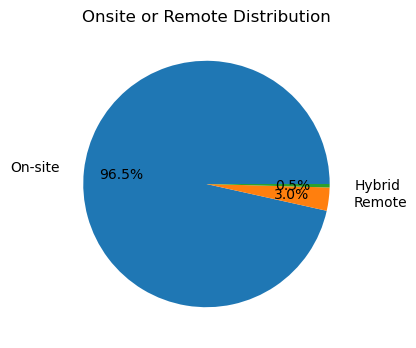

In [11]:
# PIE chart of remote_distribution
# Calculate the distribution of 'Type'
remote_distribution = df_combined['Type'].value_counts()

# Plotting the pie chart with adjusted label spacing
plt.figure(figsize=(6, 6))
remote_distribution.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=360, 
    figsize=(4, 4),
    pctdistance=0.7,  # Adjust the distance of the percentage labels from the center
    labeldistance=1.2  # Adjust the distance of the labels from the center
)
plt.title('Onsite or Remote Distribution')
plt.ylabel('')  #


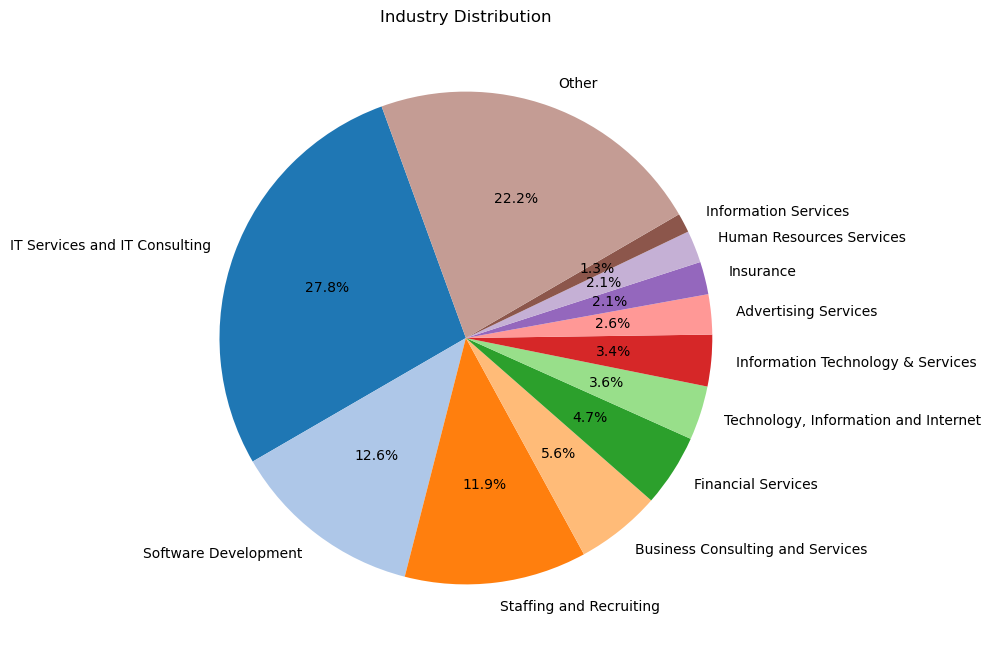

In [12]:
# Count the instances of each industry
industry_distribution = df_combined['Industry'].value_counts()

# Set a threshold to remove smaller percentages 
threshold = 50  

# Group smaller values into 'Other'
above_threshold = industry_distribution[industry_distribution > threshold]
below_threshold = industry_distribution[industry_distribution <= threshold]

# Create a new Series including the 'Other' category
other_sum = pd.Series(below_threshold.sum(), index=['Other'])
combined_distribution = pd.concat([above_threshold, other_sum])

# Define a color palette using tab20
colors = plt.get_cmap('tab20').colors

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(combined_distribution, labels=combined_distribution.index, autopct='%1.1f%%', startangle=110, colors=colors)
plt.title('Industry Distribution')
plt.ylabel('')  
plt.show()


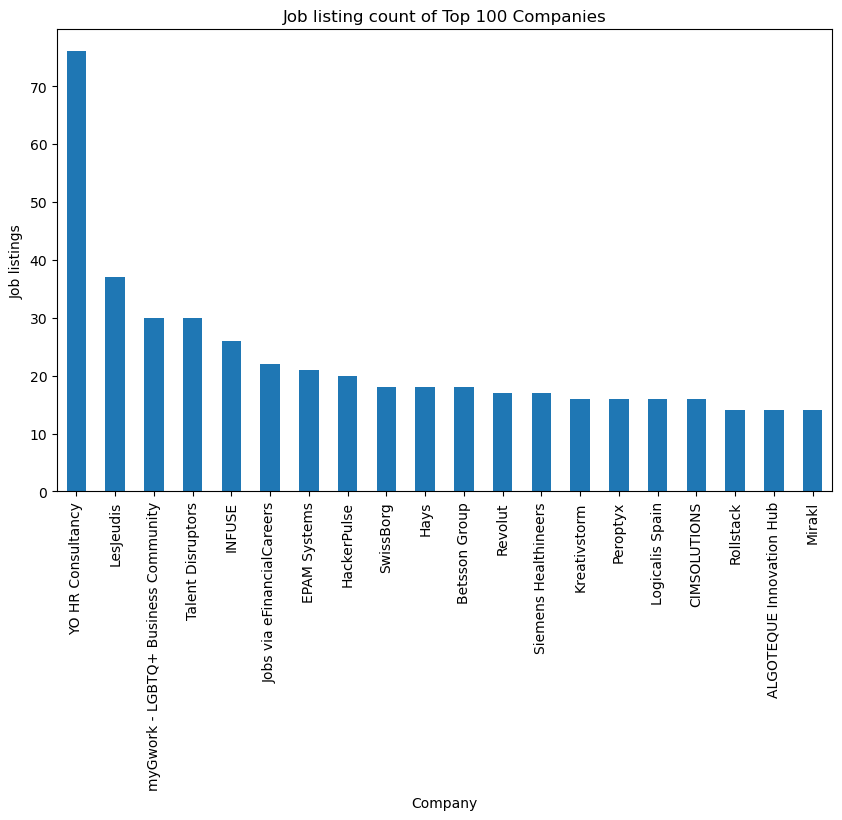

In [13]:
#Top 20 companies offering the most jobs 
# Calculate the frequency of each company
company_counts = df_combined['Company'].value_counts()

# Filter to show only the top 100 companies (or all if there are less than 100 unique companies)
top_companies = company_counts.head(20)

# Plotting the frequency of the top 100 companies
plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar')
plt.xlabel('Company')
plt.ylabel('Job listings')
plt.title('Job listing count of Top 100 Companies')
plt.xticks(rotation=90)
plt.show()


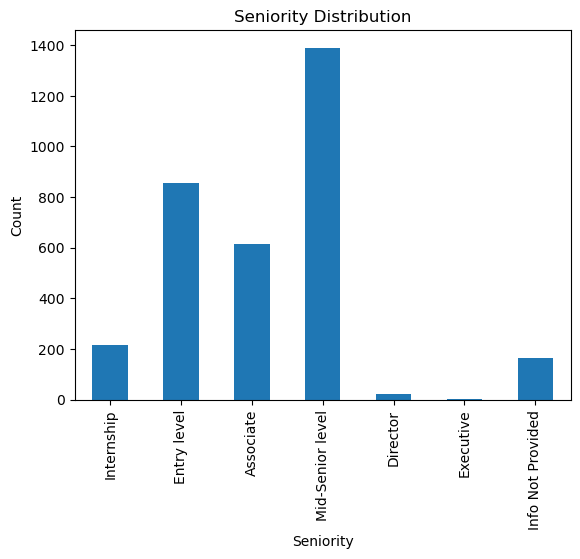

In [14]:
# Full data set Seniority Distribution 
# Define the custom order for Seniority
seniority_order = ['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive', 'Info Not Provided']

# Convert the Seniority column to a categorical type with the specified order
df_combined['Seniority'] = pd.Categorical(df_combined['Seniority'], categories=seniority_order, ordered=True)

# Count the occurrences of each seniority level
remote_distribution = df_combined['Seniority'].value_counts().reindex(seniority_order)

# Plotting Graph
remote_distribution.plot(kind='bar')

plt.title('Seniority Distribution')
plt.xlabel('Seniority')
plt.ylabel('Count')
plt.show()

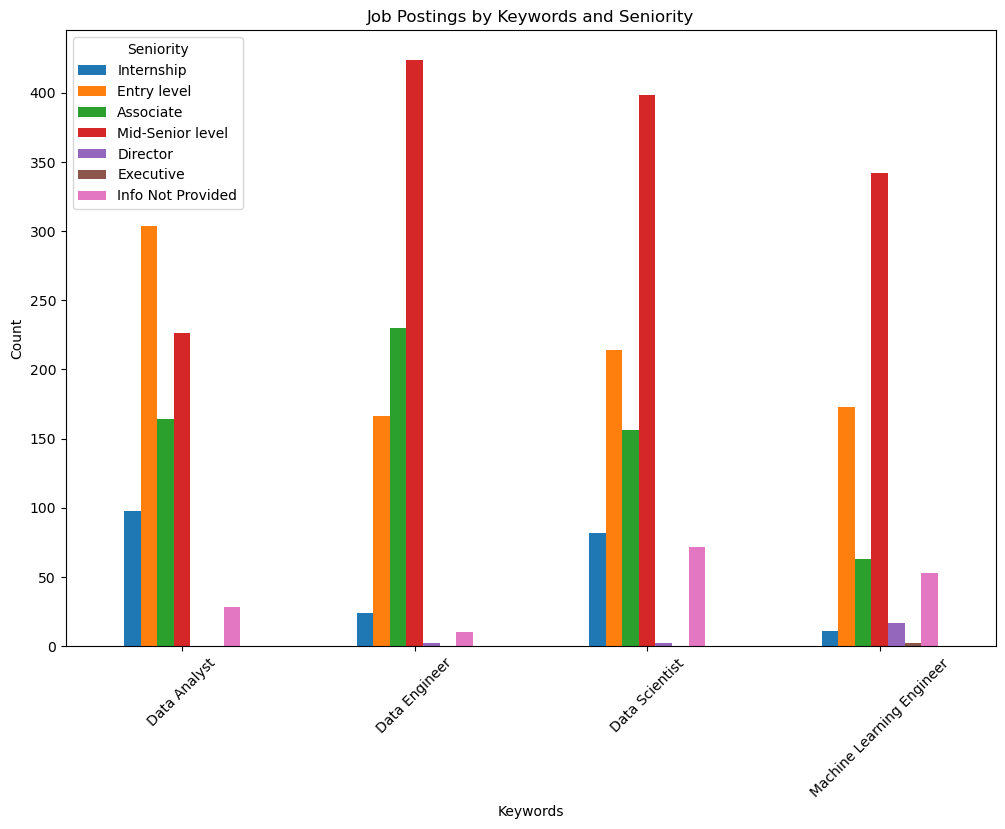

In [15]:
# Seniority Distribution grouped by Job title  

# Group by Keywords and Seniority and count the occurrences
grouped = df_combined.groupby(['Keywords', 'Seniority']).size().unstack(fill_value=0)

# Plotting Graph
grouped.plot(kind='bar', figsize=(12, 8))

plt.title('Job Postings by Keywords and Seniority')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Seniority')
plt.show()

The average age of the jobs is 19.10 days.


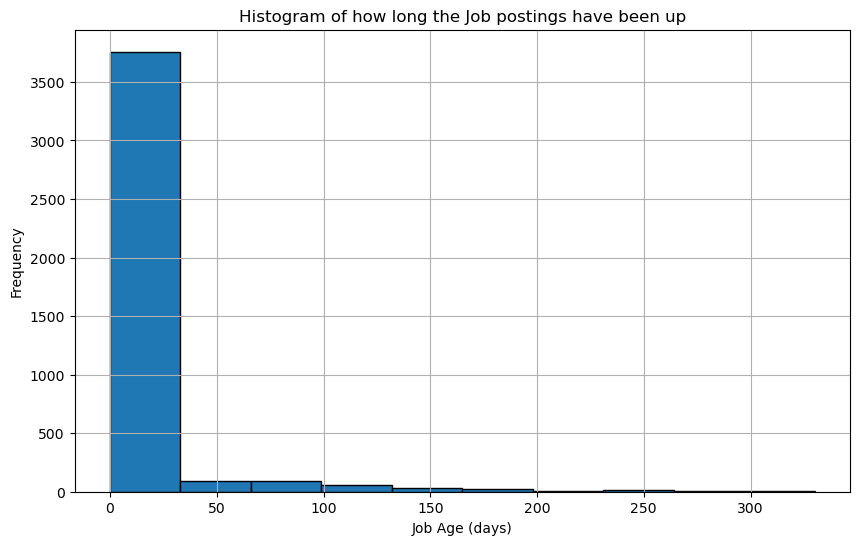

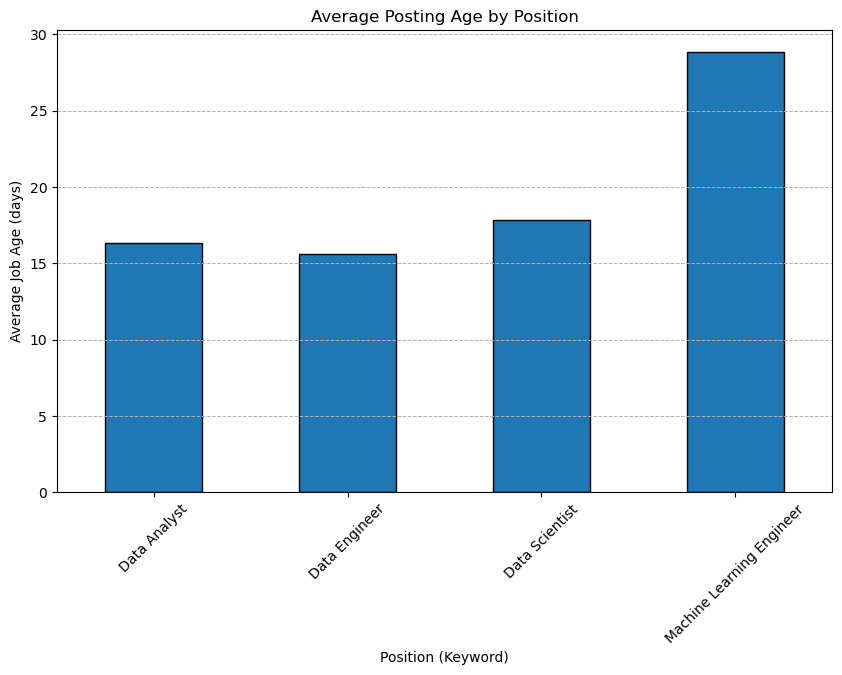

In [16]:
# Visualise age of job postings
df_combined['Job Age'] = (df_combined['Collected Date'] - df_combined['Posted']).dt.days

# Calculate the average job age
average_job_age = df_combined['Job Age'].mean()

print(f'The average age of the jobs is {average_job_age:.2f} days.')

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_combined['Job Age'], bins=10, edgecolor='black')
plt.title('Histogram of how long the Job postings have been up')
plt.xlabel('Job Age (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Group by Keywords and calculate the average job age for each keyword
average_job_age_per_keyword = df_combined.groupby('Keywords')['Job Age'].mean()


# Plotting the bar chart
plt.figure(figsize=(10, 6))
average_job_age_per_keyword.plot(kind='bar', edgecolor='black')
plt.title('Average Posting Age by Position')
plt.xlabel('Position (Keyword)')
plt.ylabel('Average Job Age (days)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

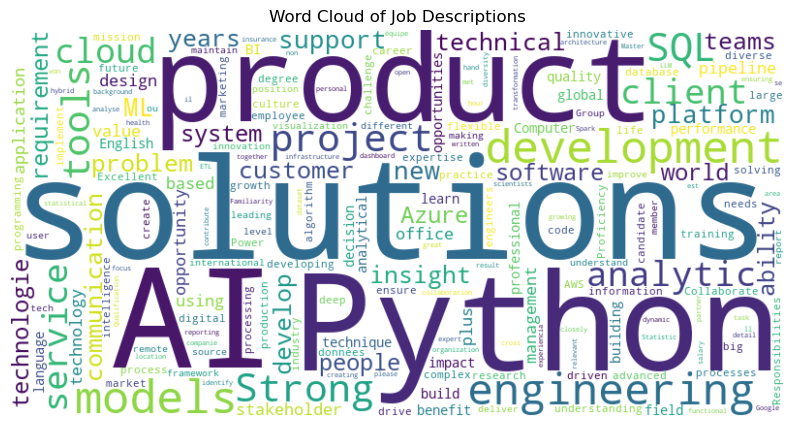

In [17]:
#Wordcloud of full dataset 
# Combine all job descriptions into a single text
text = ' '.join(df_combined['Job Description'].dropna().tolist())

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model'
])
# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    collocations=False, 
    stopwords=custom_stopwords
).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Job Descriptions')
plt.show()

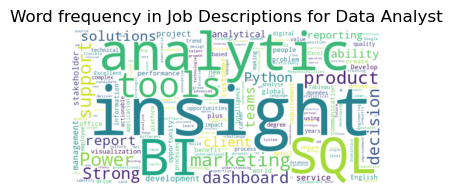

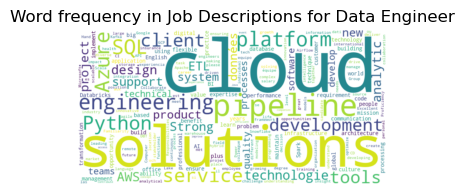

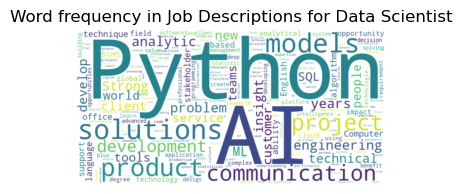

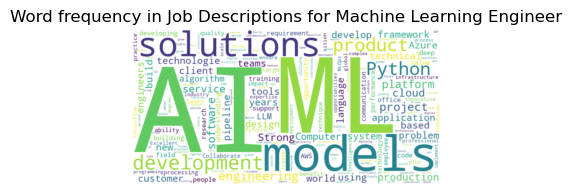

In [18]:
#Word Clouds from job description for each Job title
# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model'
])

# Loop through each unique keyword
unique_keywords = df_combined['Keywords'].unique()

for keyword in unique_keywords:
    # Filter job descriptions for the current keyword
    keyword_descriptions = df_combined[df_combined['Keywords'] == keyword]['Job Description'].dropna().tolist()
    text = ' '.join(keyword_descriptions)

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        collocations=False, 
        stopwords=custom_stopwords
    ).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(6, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f'Word frequency in Job Descriptions for {keyword}')
    plt.show()

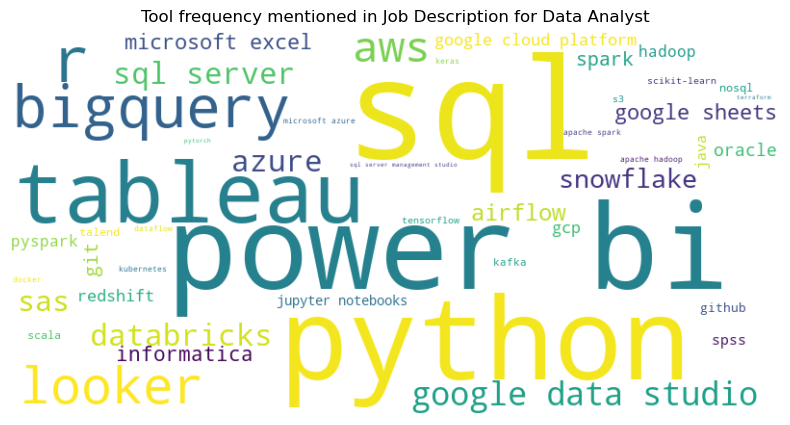

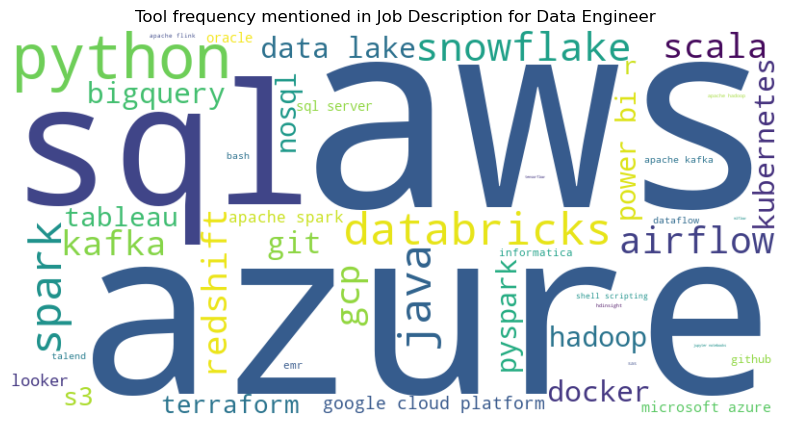

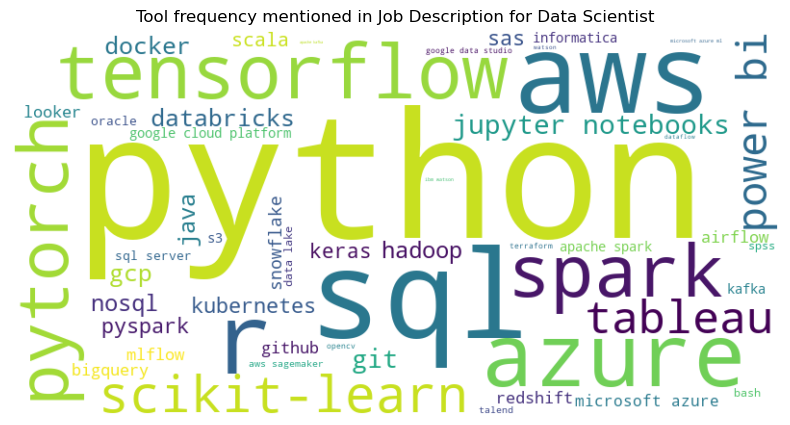

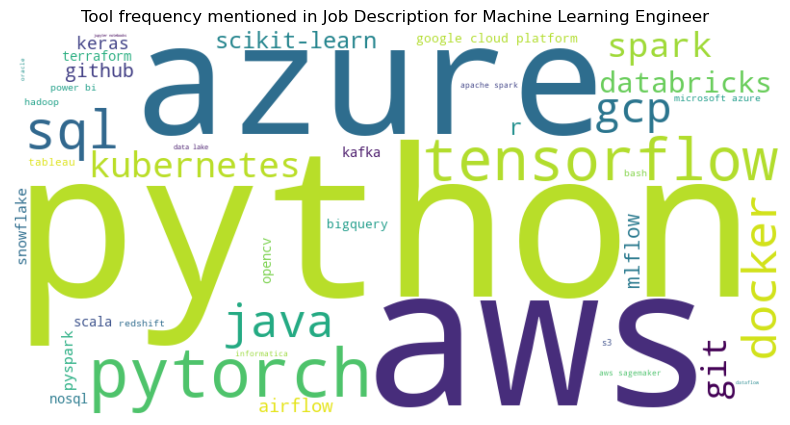

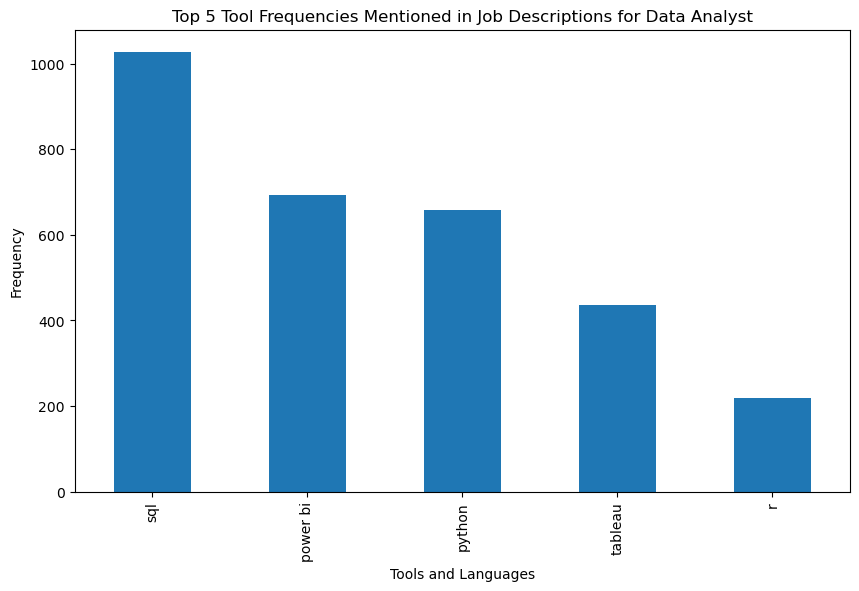

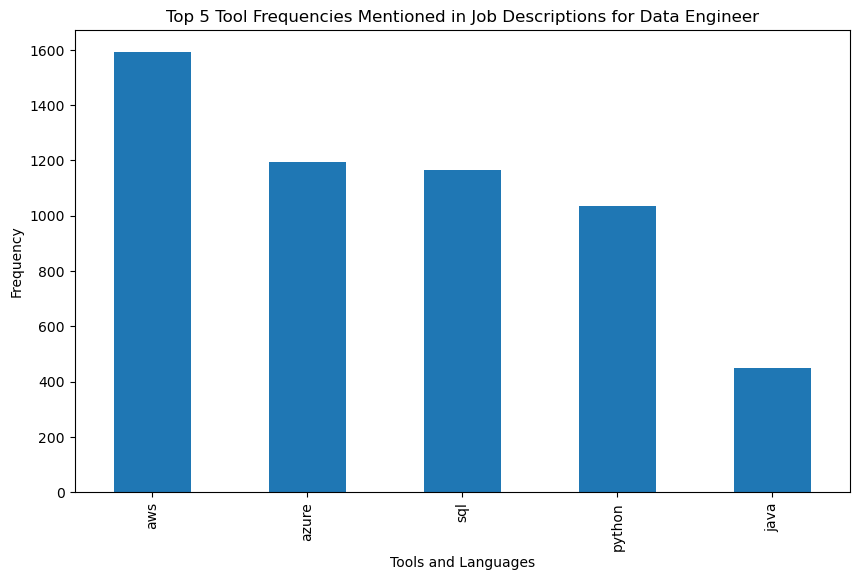

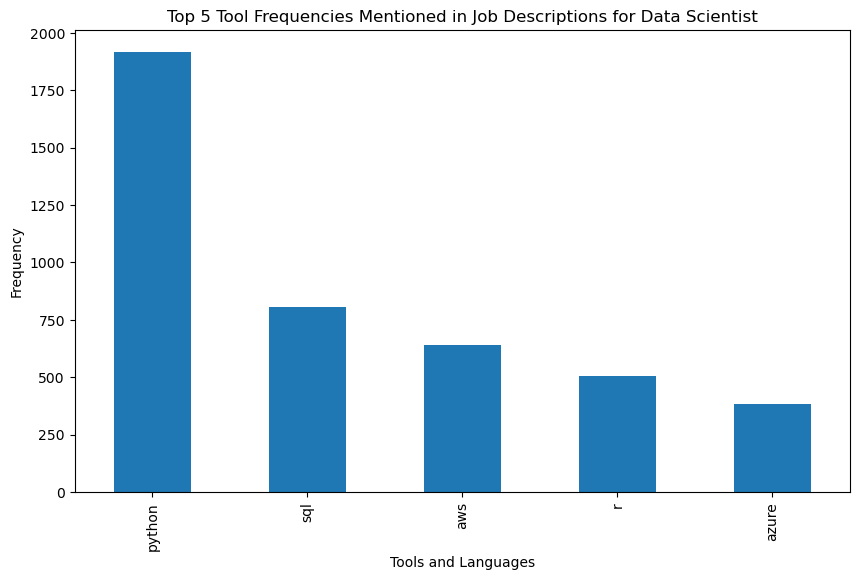

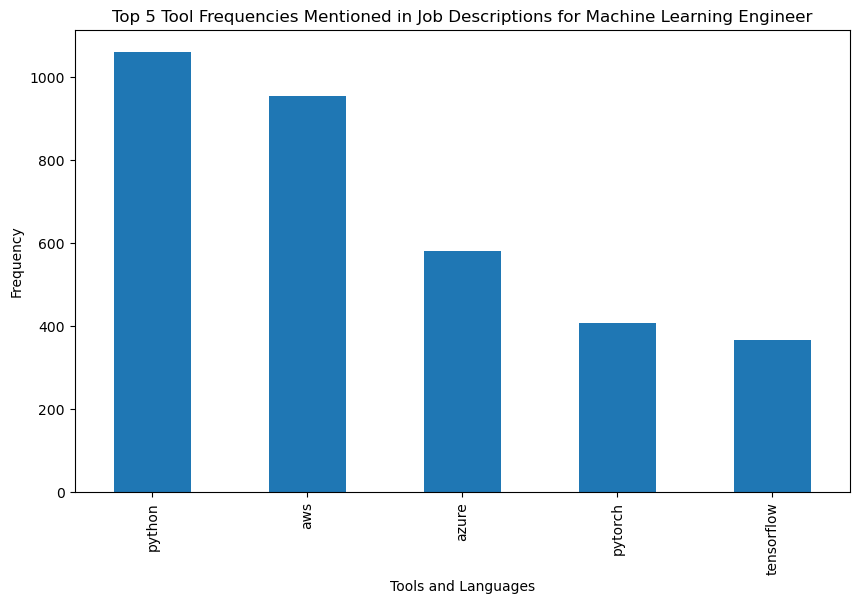

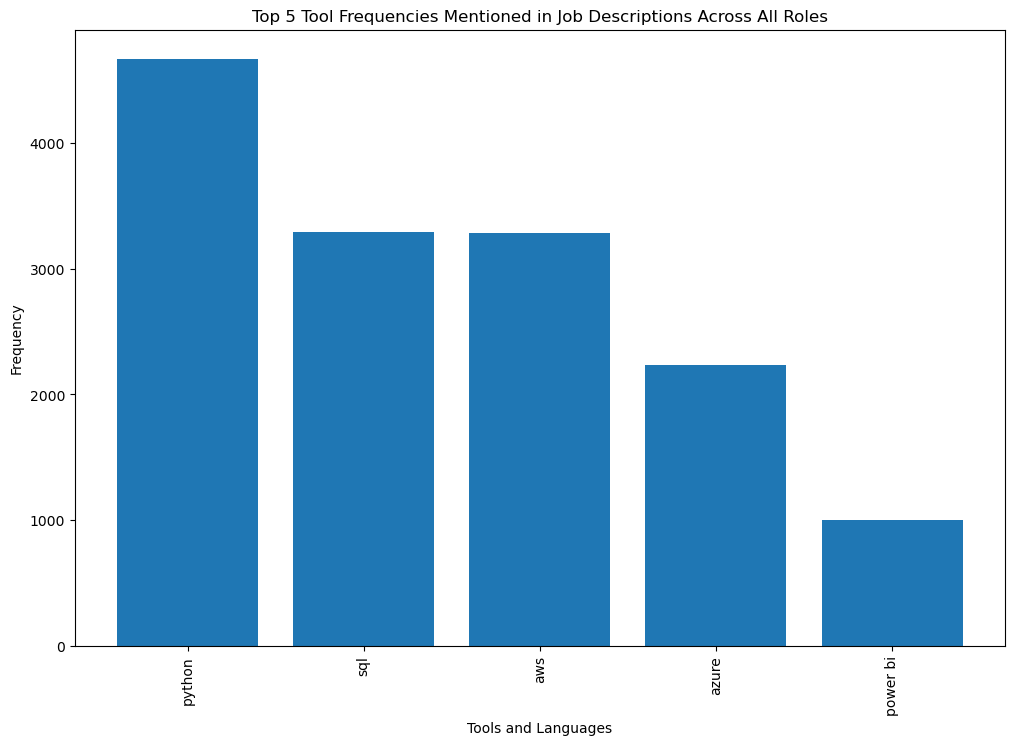

In [19]:
# List of tools and programming languages for all roles
tools_and_languages = [
    # Data Analyst
    'Microsoft Excel', 'Google Sheets', 'Tableau', 'Power BI', 'Looker', 'SAS', 'SPSS', 'SQL', 'Python', 'R',
    'Jupyter Notebooks', 'Google Data Studio', 'MySQL Workbench', 'SQL Server Management Studio',

    # Data Scientist
    'RStudio', 'Apache Hadoop', 'Apache Spark', 'TensorFlow', 'PyTorch', 'Scikit-learn', 'IBM Watson',
    'Scala', 'Git', 'GitHub', 'Docker', 'Kubernetes', 'Apache Kafka', 'Airflow',

    # Data Engineer
    'Apache Flink', 'AWS', 'Redshift', 'S3', 'EMR', 'Google Cloud Platform', 'BigQuery', 'Dataflow',
    'Microsoft Azure', 'Data Lake', 'HDInsight', 'Databricks', 'Snowflake', 'Talend', 'Informatica',
    'Java', 'Bash', 'Shell scripting', 'Terraform',

    # Machine Learning Engineer
    'Keras', 'OpenCV', 'MLflow', 'Google AI Platform', 'AWS SageMaker', 'Microsoft Azure ML',
    'C++',
    
    # Others - including variations of longer tools and languages 
    'Azure', 'Redshift', 'Oracle', 'Spark', 'Java', 'Hadoop', 'Kafka', 'AWS', 'NoSql', 'Watson', 'GCP', 'SQL Server',
    'PySpark'
]

# Convert all tools and languages to lowercase for case-insensitive matching
tools_and_languages = [tool.lower() for tool in tools_and_languages]

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'fast', 'way', 'set', 'related', 'full', 'net', 'across', 'best', 'datos', 'high', 'days', 'een', 'time',
    'Analyst', 'Engineer', 'Scientist', 'about', 'the', 'job', 'team', 'machine', 'learning', 'data', 'experience',
    'various', 'including', 'every', 'looking', 'sur', 'join', 'work', 'des', 'apply', 'provide', 'help', 'offer', 'analysis', 'skill', 'skills', 'business', 'science', 'solution',
    'working', 'role', 'tool', 'environment', 'company', 'role', 'year', 'knowledge', 
    'real', 'dans', 'donnée', 'day', 'want', 'may', 's', 'avec', 'die', 'within', 'take', 're', 'dato', 'mit', 'end',
    'part', 'van', 'los', 'may', 'key', 'una', 'au', 'ait', 'para', 'del', 'nous', 'pour', 'der', 're', 'die', 'la',
    'que', 'und', 'y', 'will', 'les', 'e', 'de', 'un', 'en', 'con', 'u', 'une', 'le', 'one', 'a', 'best offer', 'et',
    'etc', 'nos', 'je', 'o', 'di', 'te', 'd', 'well', 'good', 'need', 'make', 'dan', 'l', 'el', 'Vous', 'use', 'use',
    'and', 'du', 'à', 'al', 'lo', 'tu', 'us', 'per', 'g', 'home', 'notre', 'model'
])

# Function to count occurrences of tools and languages in job descriptions
def count_tools_and_languages(job_description, tools_and_languages, tool_counts):
    job_description = job_description.lower()
    for tool in tools_and_languages:
        # Use regular expressions to count whole words
        pattern = r'\b' + re.escape(tool) + r'\b'
        tool_counts[tool] += len(re.findall(pattern, job_description))
    return tool_counts

# Initialize a dictionary to store the counts for each role
role_tool_counts = {role: {tool: 0 for tool in tools_and_languages} for role in df_combined['Keywords'].unique()}

# Loop through each unique keyword (role)
for keyword in df_combined['Keywords'].unique():
    # Initialize a dictionary to hold counts of each tool/language for the current role
    tool_counts = {tool: 0 for tool in tools_and_languages}

    # Filter job descriptions for the current keyword (role)
    keyword_descriptions = df_combined[df_combined['Keywords'] == keyword]['Job Description'].dropna().tolist()
    for job_description in keyword_descriptions:
        tool_counts = count_tools_and_languages(job_description, tools_and_languages, tool_counts)

    # Store the counts in the role_tool_counts dictionary
    role_tool_counts[keyword] = tool_counts

    # Filter out tools/languages that were not found
    filtered_tool_counts = {k: v for k, v in tool_counts.items() if v > 0}

    # Generate a word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate_from_frequencies(filtered_tool_counts)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(f'Tool frequency mentioned in Job Description for {keyword}')
    plt.show()

# Convert the role_tool_counts dictionary to a DataFrame for easier plotting
role_tool_counts_df = pd.DataFrame(role_tool_counts).fillna(0)

# Plotting the counts for each role
for role in role_tool_counts_df.columns:
    plt.figure(figsize=(10, 6))
    role_tool_counts_df[role].sort_values(ascending=False).head(5).plot(kind='bar')
    plt.title(f'Top 5 Tool Frequencies Mentioned in Job Descriptions for {role}')
    plt.xlabel('Tools and Languages')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    
    # Aggregate counts across all roles
total_tool_counts = {tool: 0 for tool in tools_and_languages}
for role in role_tool_counts:
    for tool in role_tool_counts[role]:
        total_tool_counts[tool] += role_tool_counts[role][tool]

# Filter out tools/languages that were not found
filtered_total_tool_counts = {k: v for k, v in total_tool_counts.items() if v > 0}

# Convert to DataFrame for easier manipulation
total_tool_counts_df = pd.DataFrame(list(filtered_total_tool_counts.items()), columns=['Tool', 'Count'])
total_tool_counts_df = total_tool_counts_df.sort_values(by='Count', ascending=False).head(5)

# Plotting the top 20 tools across all roles
plt.figure(figsize=(12, 8))
plt.bar(total_tool_counts_df['Tool'], total_tool_counts_df['Count'])
plt.title('Top 5 Tool Frequencies Mentioned in Job Descriptions Across All Roles')
plt.xlabel('Tools and Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


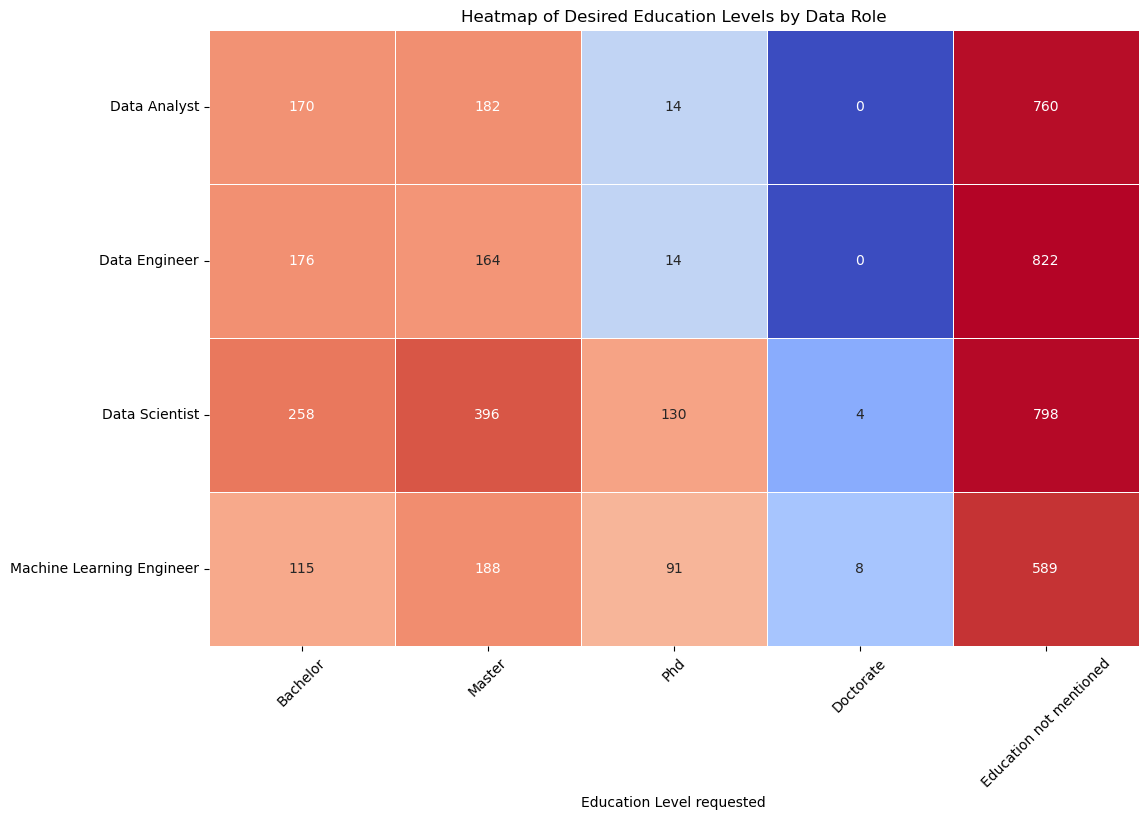

In [20]:
# Heatmap of desired education level per role
# List of education levels to check in job descriptions
education_levels = ['bachelor', 'master', 'phd', 'doctorate']

# Convert all education levels to lowercase for case-insensitive matching
education_levels = [level.lower() for level in education_levels]

# Function to count occurrences of education levels in job descriptions
def count_education_levels(job_description, education_levels):
    job_description = job_description.lower()
    education_counts = {level: 0 for level in education_levels}
    for level in education_levels:
        pattern = r'\b' + re.escape(level) + r'\b'
        education_counts[level] = len(re.findall(pattern, job_description))
    # Check if none of the education levels are mentioned
    if all(count == 0 for count in education_counts.values()):
        education_counts['Education not mentioned'] = 1
    else:
        education_counts['Education not mentioned'] = 0
    return education_counts

# Initialize a list to store the counts for each role
role_education_counts_list = []

# Process each job description
for index, row in df_combined.iterrows():
    role = row['Keywords']
    job_description = row['Job Description']
    
    # Count education levels in the job description
    education_counts = count_education_levels(job_description, education_levels)
    
    # Add the counts to the list
    education_counts['role'] = role
    role_education_counts_list.append(education_counts)

# Convert the list to a DataFrame
role_education_counts = pd.DataFrame(role_education_counts_list)

# Aggregate counts by role
role_education_counts = role_education_counts.groupby('role').sum().reset_index()

# Pivot the DataFrame for heatmap
heatmap_data = role_education_counts.set_index('role')

# Convert the values to integers to avoid scientific notation
heatmap_data = heatmap_data.applymap(int)

# Apply log transformation to the data
heatmap_data_log = heatmap_data.applymap(lambda x: np.log1p(x))

# Plot heatmap
plt.figure(figsize=(12, 8))
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with annotations
ax = sns.heatmap(heatmap_data_log, annot=heatmap_data, fmt='d', cmap=cmap, linewidths=0.5, cbar=False)

plt.title('Heatmap of Desired Education Levels by Data Role')
plt.xlabel('Education Level requested')
ax.set_ylabel('')

plt.xticks(rotation=45)

# Capitalize x-axis labels
current_labels = [label.get_text() for label in ax.get_xticklabels()]
capitalized_labels = [label.capitalize() for label in current_labels]
ax.set_xticklabels(capitalized_labels)

plt.yticks(rotation=0)
plt.show()


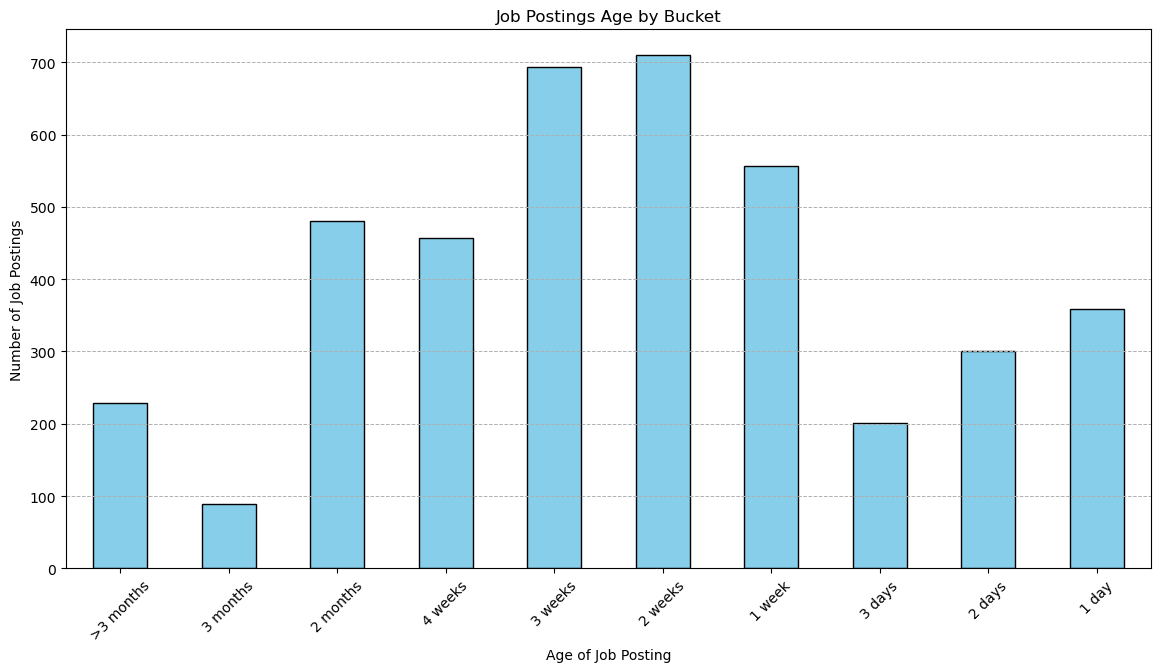

In [21]:
# Calculate the age of each job posting in days relative to the 'Collected Date'
df_combined['Days Ago'] = (df_combined['Collected Date'] - df_combined['Posted']).dt.days

# Define the buckets based on LinkedIn's increments
bins = [0, 1, 2, 3, 7, 14, 21, 28, 60, 90, np.inf]
labels = ['1 day', '2 days', '3 days', '1 week', '2 weeks', '3 weeks', '4 weeks', '2 months', '3 months', '>3 months']

# Categorize the postings into these buckets
df_combined['Bucket'] = pd.cut(df_combined['Days Ago'], bins=bins, labels=labels, right=False)

# Count the frequency of job postings in each bucket
bucket_counts = df_combined['Bucket'].value_counts().reindex(labels, fill_value=0)

# Plotting the data
plt.figure(figsize=(14, 7))
bucket_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Job Postings Age by Bucket')
plt.xlabel('Age of Job Posting')
plt.ylabel('Number of Job Postings')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.gca().invert_xaxis()  # Reverse the order of the x-axis to match visual above
plt.show()

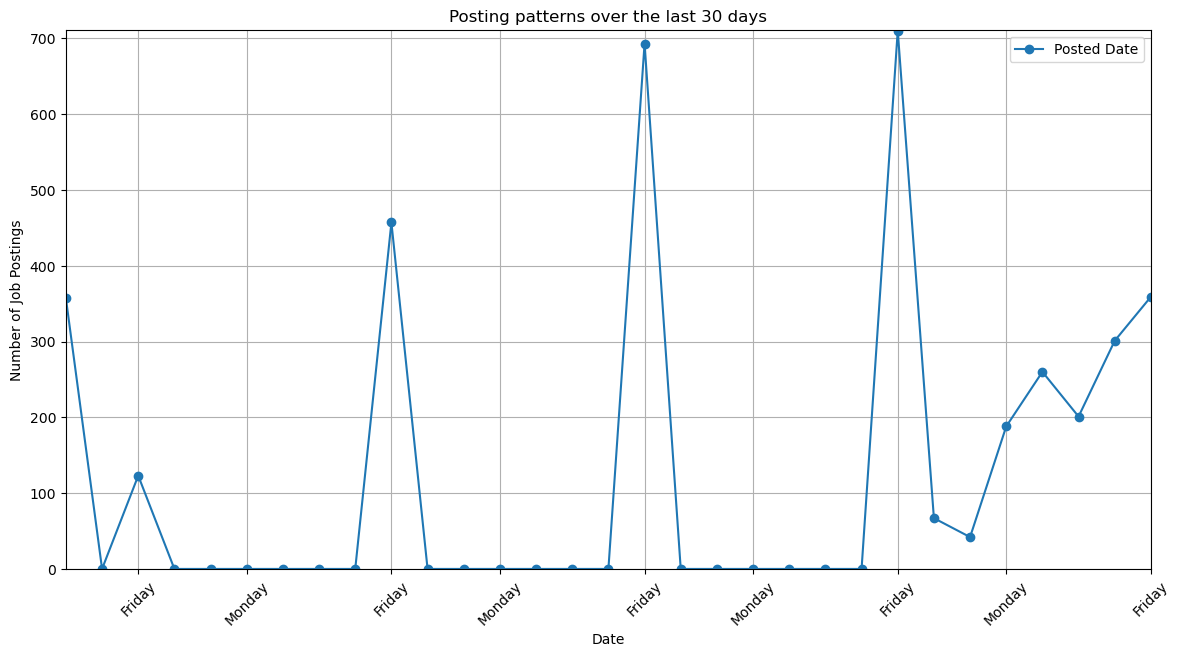

In [22]:
#Posting patterns over the last 30 days - Data is bucketed by linkedin after 7 days. 
# Determine the latest date in the 'Posted' column
latest_date = df_combined['Posted'].max()

# Calculate the date 10 days before the latest date
x_days_ago = latest_date - pd.DateOffset(days=30)

# Filter the data for the last 10 days
filtered_df = df_combined[df_combined['Posted'] >= x_days_ago].copy()

# Check if filtered_df is empty
if filtered_df.empty:
    print("No data available for the last 10 days.")
else:
    # Remove the time component for accurate resampling
    filtered_df.loc[:, 'Posted'] = filtered_df['Posted'].dt.normalize()

    # Resample the data to count the number of job postings per day
    posted_count = filtered_df.set_index('Posted').resample('D').size()

    # Create a date range for the last 10 days to ensure all days are included
    date_range = pd.date_range(start=x_days_ago, end=latest_date, freq='D')

    # Reindex the counts to ensure they match the date range and fill missing values with 0
    posted_count = posted_count.reindex(date_range, fill_value=0)

    # Add a column for day names
    posted_count.index = posted_count.index.to_series()
    posted_count.index.name = 'Date'
    posted_count = posted_count.reset_index()
    posted_count['Day'] = posted_count['Date'].dt.day_name()

    # Filter for Mondays and Fridays only for x-ticks
    xticks = posted_count[posted_count['Date'].dt.dayofweek.isin([0, 4])]

    # Plotting the time series with day names on x-axis
    plt.figure(figsize=(14, 7))
    plt.plot(posted_count['Date'], posted_count[0], label='Posted Date', marker='o')
    plt.title('Posting patterns over the last 30 days')
    plt.xlabel('Date')
    plt.ylabel('Number of Job Postings')
    plt.legend()
    plt.grid(True)
    plt.xlim([x_days_ago, latest_date])
    plt.ylim(0, posted_count[0].max() + 1)  # Adding 1 to ensure the highest point is visible
    plt.xticks(ticks=xticks['Date'], labels=xticks['Day'], rotation=45)
    plt.show()


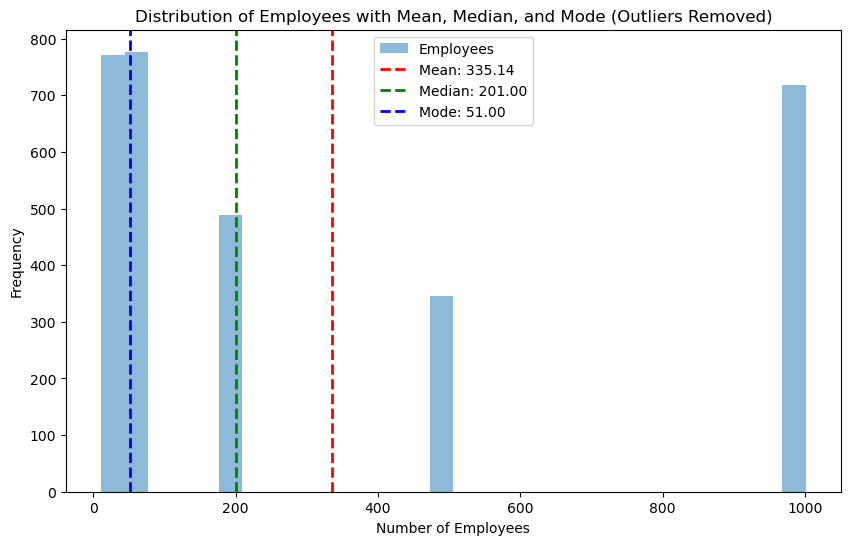

In [23]:
#Distribution of Employees with Mean, Median, and Mode (Outliers Removed)
# Remove outliers with 0 employees and over 10000
df_combined = df_combined[(df_combined['Employees'] > 9) & (df_combined['Employees'] < 4000)]

# Recalculate mean, median, and mode after removing outliers
mean_employees = df_combined['Employees'].mean()
median_employees = df_combined['Employees'].median()
mode_employees = df_combined['Employees'].mode()[0]

# Plotting the mean, median, and mode after removing outliers
plt.figure(figsize=(10, 6))
plt.hist(df_combined['Employees'], bins=30, alpha=0.5, label='Employees')
plt.axvline(mean_employees, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_employees:.2f}')
plt.axvline(median_employees, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_employees:.2f}')
plt.axvline(mode_employees, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {mode_employees:.2f}')
plt.legend()
plt.xlabel('Number of Employees')
plt.ylabel('Frequency')
plt.title('Distribution of Employees with Mean, Median, and Mode (Outliers Removed)')
plt.show()



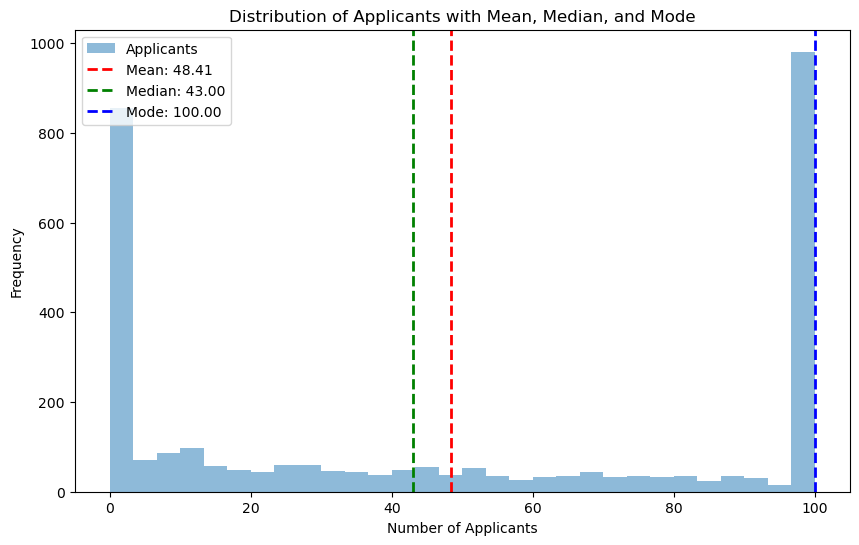

In [24]:
#Distribution of Applicants with Mean, Median, and Mode

# Recalculate mean, median, and mode for 'Applicants'
mean_applicants = df_combined['Applicants'].mean()
median_applicants = df_combined['Applicants'].median()
mode_applicants = df_combined['Applicants'].mode()[0]

# Plotting the mean, median, and mode for 'Applicants' after removing outliers
plt.figure(figsize=(10, 6))
plt.hist(df_combined['Applicants'], bins=30, alpha=0.5, label='Applicants')
plt.axvline(mean_applicants, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_applicants:.2f}')
plt.axvline(median_applicants, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_applicants:.2f}')
plt.axvline(mode_applicants, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {mode_applicants:.2f}')
plt.legend()
plt.xlabel('Number of Applicants')
plt.ylabel('Frequency')
plt.title('Distribution of Applicants with Mean, Median, and Mode')
plt.show()

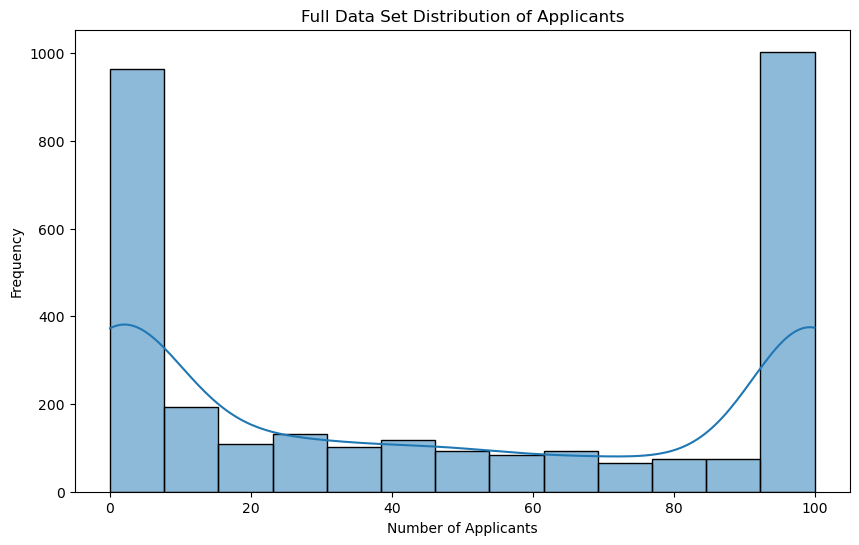

<Figure size 1400x800 with 0 Axes>

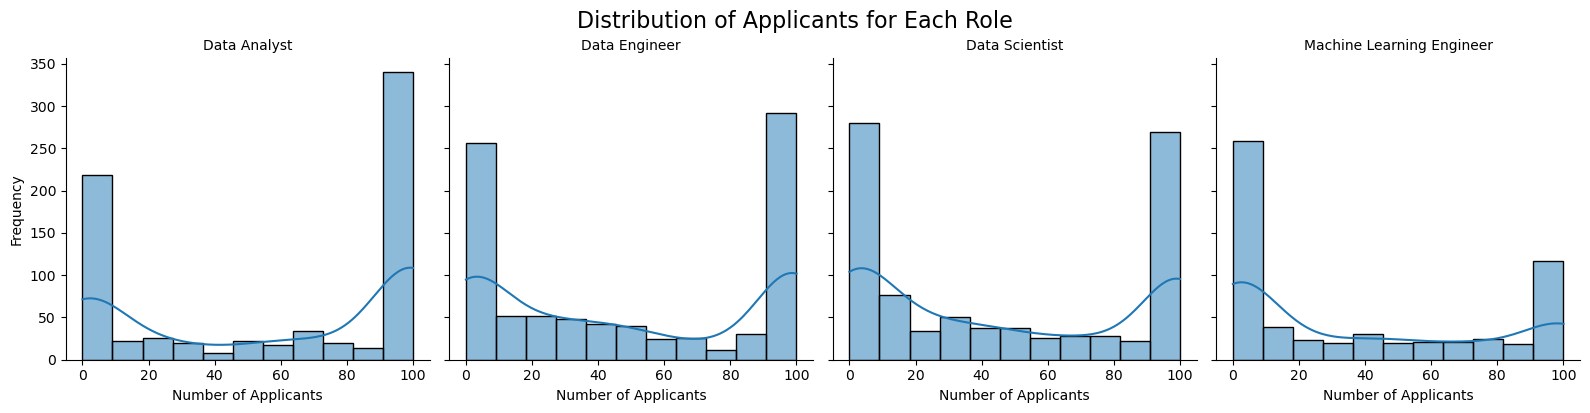

In [59]:
# Distribution of Applicants for Each Role

# Display basic descriptive statistics
# print(df_combined['Applicants'].describe())

# Plot the distribution of the 'Applicants' column
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Applicants'], kde=True)
plt.title('Full Data Set Distribution of Applicants')
plt.xlabel('Number of Applicants')
plt.ylabel('Frequency')
plt.show()


# Plot the distribution of 'Applicants' for each role in 'Keywords'
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(df_combined, col="Keywords", col_wrap=4, height=4)
g.map(sns.histplot, "Applicants", kde=True)

# Titles and labels
g.set_axis_labels('Number of Applicants', 'Frequency')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.9)  
g.fig.suptitle('Distribution of Applicants for Each Role', fontsize=16, y=1.02)  

plt.show()


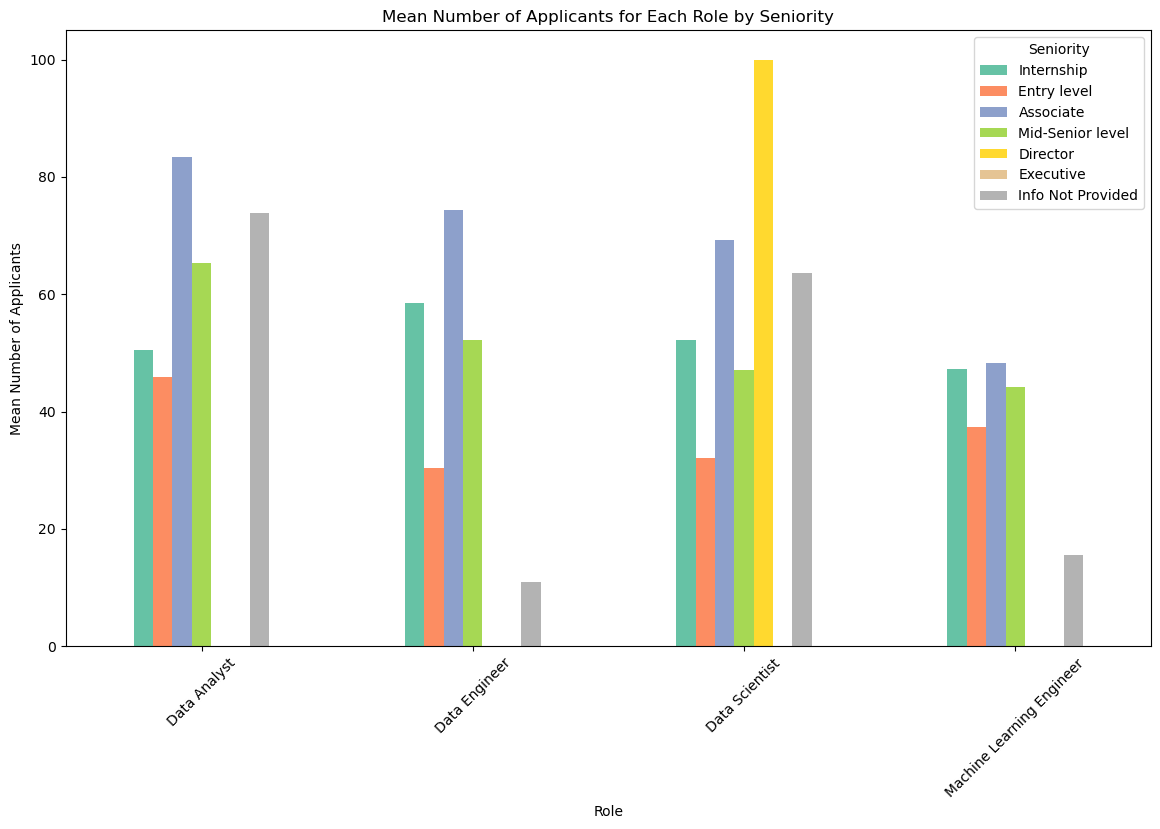

In [44]:
# Mean Number of Applicants for Each Role by Seniority
# Compute the mean number of applicants for each role and seniority level
mean_counts = df_combined.groupby(['Keywords', 'Seniority'])['Applicants'].mean().unstack(fill_value=0)

# Plot the mean number of applicants using a bar plot
mean_counts.plot(kind='bar', figsize=(14, 8), colormap='Set2')
plt.title('Mean Number of Applicants for Each Role by Seniority')
plt.xlabel('Role')
plt.ylabel('Mean Number of Applicants')
plt.xticks(rotation=45)
plt.legend(title='Seniority')
plt.show()


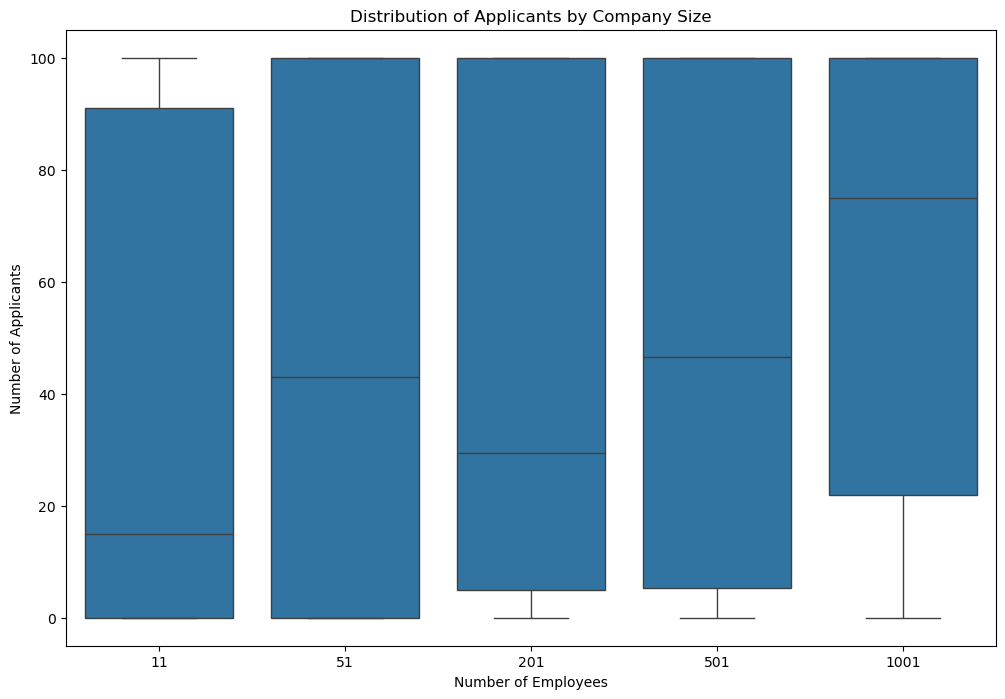

In [61]:
# Display the boxplot of 'Applicants' vs 'Employees'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Employees', y='Applicants', data=df_combined)
plt.title('Distribution of Applicants by Company Size')
plt.xlabel('Number of Employees')
plt.ylabel('Number of Applicants')
plt.show()



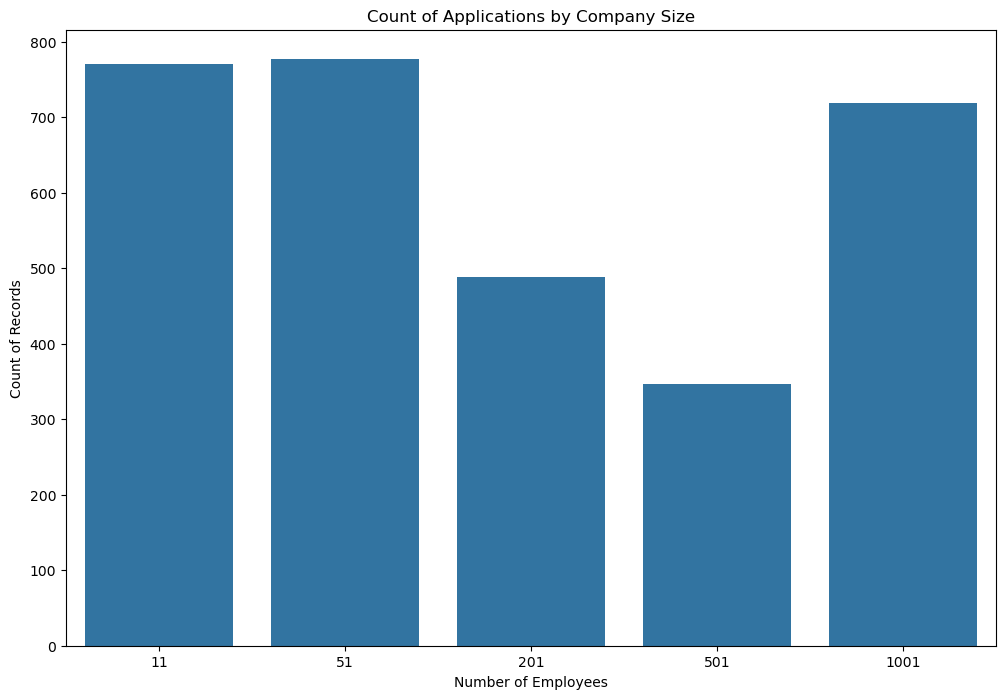

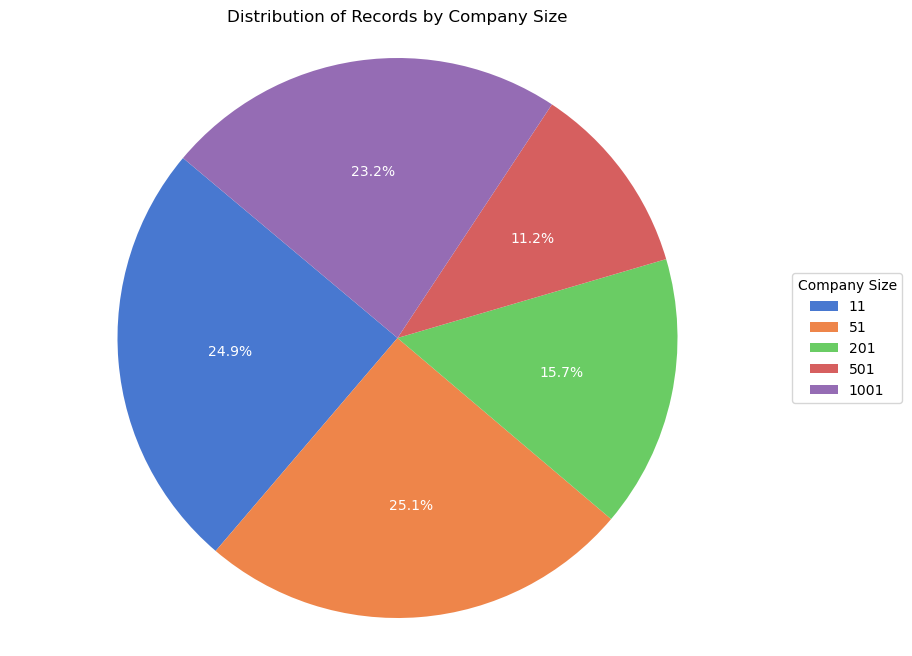

In [65]:
# Count the number of applications for each company size
company_size_counts = df_combined['Employees'].value_counts().sort_index()

# Plot the bar chart of record counts vs company size
plt.figure(figsize=(12, 8))
sns.barplot(x=company_size_counts.index, y=company_size_counts.values)
plt.title('Count of Applications by Company Size')
plt.xlabel('Number of Employees')
plt.ylabel('Count of Records')
plt.show()

# Choose a color palette
colors = sns.color_palette("muted")

# Plot the pie chart of record counts vs company size
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    company_size_counts.values, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors[:len(company_size_counts)], 
    textprops=dict(color="w")
)


plt.legend(wedges, company_size_counts.index, title="Company Size", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution of Records by Company Size')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
